# Neural Style Transfer (NST)

The process of NST assumes an input image p and an example style image a.
The image p is fed through a pretrained CNN, and network activations are sampled at a late convolution layer of the CNN architecture (original paper used VGG-19). Let C(p) be the resulting output sample, called the 'content' of the input p.
The style image a is then fed through the same CNN, and network activations are sampled at the early to middle layers of the CNN. These activations are encoded into a Gramian matrix representation, call it S(a) to denote the 'style' of a.
The goal of NST is to synthesize an output image x that exhibits the content of p applied with the style of a, i.e. C(x)=C(p) and S(x)=S(a).
An iterative optimization (usually gradient descent) then gradually updates x to minimize the loss function error:
L(x)=∣C(x)−C(p)∣+k∣S(x)−S(a)∣, where ∣⋅∣ is the L2 distance. The constant k controls the level of the stylization effect. 

Note: text copied from Wikipedia

In [5]:
import os
os.getcwd()

'c:\\Users\\s_gue\\Desktop\\ML_basics'

c:\Users\s_gue\anaconda3\envs\ml_basics\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


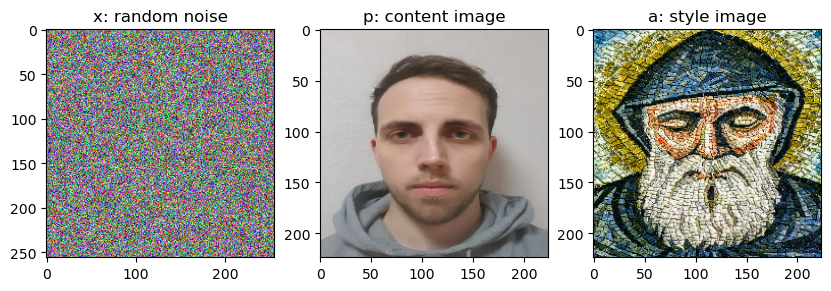

In [102]:
import numpy as numpy
import matplotlib.pyplot as plt
import torch
import torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x = torch.rand(3, 256, 256).to(device) 
x.requires_grad = True # to optimize it with GD
p = torchvision.io.read_image(path = "./files/profile_pic.jpg").to(device).type(torch.float32)/255.0
a = torchvision.io.read_image(path = "./files/mosaic_style.jpg").to(device).type(torch.float32)/255.0

#resize images to fit expected VGG dimensions
p = torchvision.transforms.functional.resize(img = p, size = [224, 224], interpolation = torchvision.transforms.InterpolationMode.BILINEAR)
a = torchvision.transforms.functional.resize(img = a, size = [224, 224], interpolation = torchvision.transforms.InterpolationMode.BILINEAR)

#show both images next to each other:
plt.figure(figsize = (10, 10))
plt.subplot(1, 3, 1)
plt.title("x: random noise")
plt.imshow(x.permute(1, 2, 0).cpu().detach().numpy())
plt.subplot(1, 3, 2)
plt.title("p: content image")
plt.imshow(p.permute(1, 2, 0).cpu().detach().numpy())
plt.subplot(1, 3, 3)
plt.title("a: style image")
plt.imshow(a.permute(1, 2, 0).cpu().detach().numpy())

In [66]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import pytorch_lightning as pl

class NST_model(pl.LightningModule):
    def __init__(self, x):
        super().__init__()
        self.x = nn.Parameter(x.clone()) #nn.Parameter specifies that this is an updateable parameter
        self.loss = nn.MSELoss()

    def forward(self, dummy_input):
        return self.x
    
    def training_step(self, batch, batch_idx):
        dummy_input, content_target = batch
        output = self(dummy_input)
        loss = self.loss(output, content_target)
        print(loss)
        #plt.imshow(self.x.permute(1, 2, 0).cpu().detach().numpy())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)

# We set the updateable parameters of the model to be the random input image x
# We are comparing x with the content image p instead of an input. Bc Pytorch expects an input, 
# we need to create a dummy loader (that loads no input, but only uses p as the target)   
class NST_dataset(Dataset):
    def __init__(self, content_image, style_image):
        self.content_image = content_image
        #self.style_image = style_image
    def __len__(self):
        return 1
    def __getitem__(self, idx):
        return 0, self.content_image #, self.style_image

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type    | Params
-----------------------------------------
0 | loss         | MSELoss | 0     
  | other params | n/a     | 196 K 
-----------------------------------------
196 K     Trainable params
0         Non-trainable params
196 K     Total params
0.786     Total estimated model params size (MB)
c:\Users\s_gue\anaconda3\envs\ml_basics\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\s_gue\anaconda3\envs\ml_basics\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (1) is smaller than the logging i

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

tensor(0.1253, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=10]         

c:\Users\s_gue\anaconda3\envs\ml_basics\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 3, 256, 256])) that is different to the input size (torch.Size([3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0987, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 41.53it/s, v_num=10]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 24.02it/s, v_num=10]


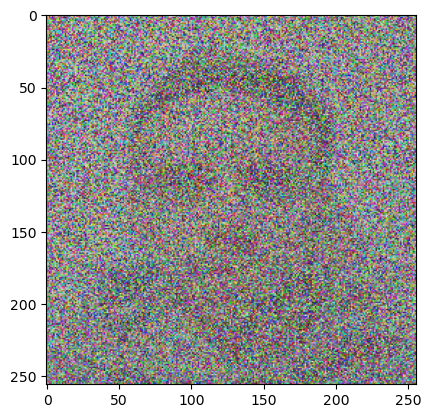

In [67]:
model = NST_model(x)
dataset = NST_dataset(p, a)
trainer = pl.Trainer(max_epochs=10)
dataloader = DataLoader(dataset, batch_size=1)
trainer.fit(model, dataloader)

The original paper used VGG19 to extract content and style features as follows: 
"The images [...] were synthesised by matching the content representation on layer ‘conv4_2’ 
and the style representation on layers‘conv1_1’, ‘conv2_1’, ‘conv3_1’, ‘conv4_1’ and ‘conv5_1’
(wl = 1/5 in those layers, wl = 0 in all other layers)."

L. A. Gatys, A. S. Ecker and M. Bethge, "Image Style Transfer Using Convolutional Neural Networks," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, 2016, pp. 2414-2423, doi: 10.1109/CVPR.2016.265.

--> Early layers tend to capture gradients and textures, while later layers tend towards more complex types of feature.

In [71]:
import torchvision.models as models

# Load the pretrained VGG19 model
vgg19 = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
vgg19.eval() # freeze the model
vgg19.to(device) # move the model to GPU

#Let's have a look at the model architecture
vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [95]:
vgg19.features[5]

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

We need to get the model's output at different layers. The most efficient way is to use a forward hook and store the layers in a list.

In [144]:
# Create a callable for the hooks
class Get_Layer_Output:
 def __init__(self):
    self.outputs = []

 def __call__(self, module, module_in, module_out):
    self.outputs.append(module_out)

 def clear(self):
    self.outputs = []

get_layer_output = Get_Layer_Output()
hook_handles = []

layer_ids = [2, 5]
for layer in vgg19.features.children():
    if not layer_ids:
        break  # Stop iterating once all specified layers are found
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        if layer == vgg19.features[layer_ids[0]]:
            handle = layer.register_forward_hook(get_layer_output)
            hook_handles.append(handle)
            layer_ids.pop(0)

# Forward pass with your input data
# Assuming your input data is stored in the variable input_data
out = vgg19(p[None,...])

VGG19 expects normalized values + we need to add a batch dimension

In [ ]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
p = normalize(p)
p = p[None,...]

Note to myself: we need to clean the hook after every call cause it keeps appending

In [155]:
get_layer_output.outputs[1].shape

torch.Size([1, 128, 112, 112])